In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import permutations
from sklearn.linear_model import LogisticRegression
from helper import *
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle

### Feature Engineering

Intuition: we want hard majors, and there course levels. We also want same major courses as they are more related. 

In [3]:
course_df = feature_engineer("CS-4820")

776 students pre-enrolled in CS-4820
3 data point is nan during processing
Sanity check passed
30 students dropped


In [4]:
course_df['dropped'].value_counts()

0    743
1     30
Name: dropped, dtype: int64

In [5]:
course_df

,semester,dropped,num_course,num_eng_course,num_same_dept_course,course_level_sum,year,sem_fall,sem_spring
0,sp22,0,4,3,3,13,2022,0,1
1,sp22,0,1,1,1,4,2022,0,1
2,sp22,0,2,2,2,8,2022,0,1
3,sp22,0,5,2,1,15,2022,0,1
4,sp22,0,3,3,2,12,2022,0,1
...,...,...,...,...,...,...,...,...,...
771,sp23,0,3,3,1,10,2023,0,1
772,sp23,0,4,4,3,11,2023,0,1
773,sp23,0,3,3,2,11,2023,0,1
774,sp23,0,3,2,2,9,2023,0,1


## Use SP22 and FA22 as train, and SP23 as test

### Train Test Split

In [221]:
x_train, y_train, x_test, y_test = make_semester_specific_train_test(course_df, target_sem = "sp23",
                                                                     past_sems = ["fa22", "sp22"])

17 students dropped in the train data


### Perform Prediction

In [222]:
model = LogisticRegression(random_state = 2)
model.fit(x_train, y_train)

LogisticRegression(random_state=2)

In [223]:
model.score(x_test, y_test)

0.9326424870466321

In [224]:
print('In-sample prediction:')
print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_train)[:,1]))
print('Actual number of student dropped: ', np.sum(y_train) )

In-sample prediction:
Expected number of people that will drop:  16.999941622399007
Actual number of student dropped:  17


In [225]:
# Expected number of people that will drop
print('Out-of-sample prediction:')
print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_test)[:,1]))
print('Actual number of student dropped: ', np.sum(y_test) )

Out-of-sample prediction:
Expected number of people that will drop:  5.782716942515956
Actual number of student dropped:  13


In [226]:
# calculate performance metrics
y_pred = model.predict(x_test)
# calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# print confusion matrix
print(f"{'':<10} {'Predicted 0':<15} {'Predicted 1':<15}")
print(f"{'Actual 0':<10} {tn:<15} {fp:<15}")
print(f"{'Actual 1':<10} {fn:<15} {tp:<15}")

           Predicted 0     Predicted 1    
Actual 0   180             0              
Actual 1   13              0              


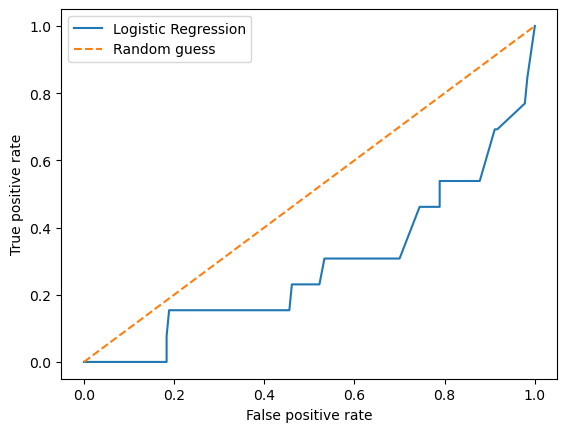

In [227]:
# calculate ROC curve
y_prob = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

In [228]:
# Calculate AUC score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.9326424870466321
Precision: 0.0
Recall: 0.0
F1 score: 0.0


C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC score: 0.28547008547008546
Cross-validation scores: [0.96129032 0.96129032 0.96129032 0.96103896 0.96103896]
Mean cross-validation score: 0.9611897779639715


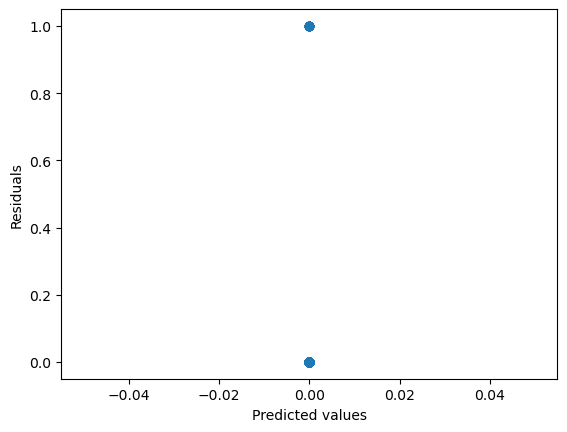

In [229]:
auc_score = roc_auc_score(y_test, y_prob)
print("AUC score:", auc_score)

X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)
# perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# perform residual analysis
residuals = y_test - y_pred
plt.scatter(model.predict(x_test), residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

## Random Train test split

In [230]:
# x_train, y_train, x_test, y_test = make_random_train_test(course_df, train_ratio = 0.7, random_state = 2)
X = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

In [231]:
model = LogisticRegression(random_state = 2)
model.fit(x_train, y_train)

LogisticRegression(random_state=2)

In [232]:
model.score(x_test, y_test)

0.9612903225806452

In [233]:
print('In-sample prediction:')
print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_train)[:,1]))
print('Actual number of student dropped: ', np.sum(y_train) )

In-sample prediction:
Expected number of people that will drop:  24.00168475314822
Actual number of student dropped:  24


In [234]:
# Expected number of people that will drop
print('Out-of-sample prediction:')
print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_test)[:,1]))
print('Actual number of student dropped: ', np.sum(y_test) )

Out-of-sample prediction:
Expected number of people that will drop:  5.8025563148056145
Actual number of student dropped:  6


In [235]:
# calculate performance metrics
y_pred = model.predict(x_test)
# calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# print confusion matrix
print(f"{'':<10} {'Predicted 0':<15} {'Predicted 1':<15}")
print(f"{'Actual 0':<10} {tn:<15} {fp:<15}")
print(f"{'Actual 1':<10} {fn:<15} {tp:<15}")

           Predicted 0     Predicted 1    
Actual 0   149             0              
Actual 1   6               0              


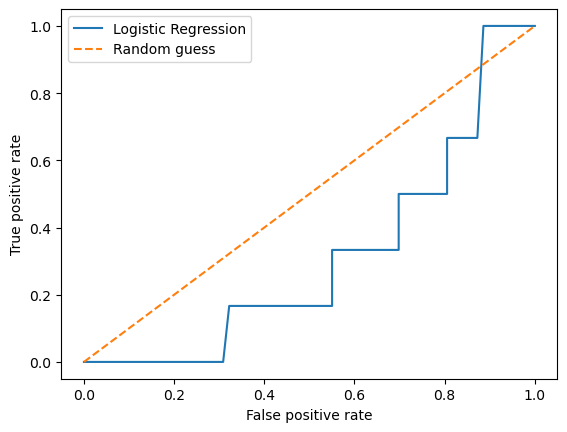

In [236]:
# calculate ROC curve
y_prob = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label="Logistic Regression")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random guess")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

In [237]:
# Calculate AUC score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

Accuracy: 0.9612903225806452
Precision: 0.0
Recall: 0.0
F1 score: 0.0


C:\Users\USER\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC score: 0.31208053691275167
Cross-validation scores: [0.96129032 0.96129032 0.96129032 0.96103896 0.96103896]
Mean cross-validation score: 0.9611897779639715


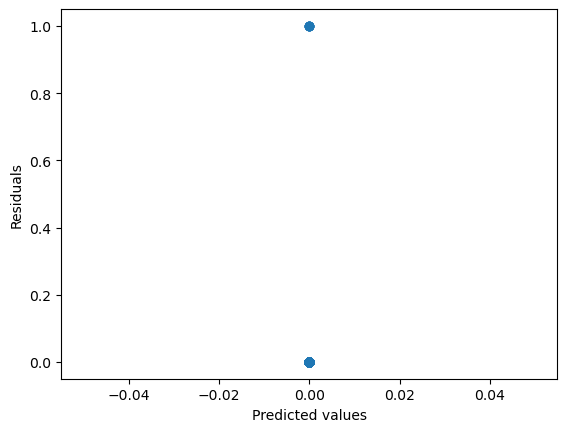

In [238]:
auc_score = roc_auc_score(y_test, y_prob)
print("AUC score:", auc_score)

X = np.concatenate((x_train, x_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)
# perform cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

# perform residual analysis
residuals = y_test - y_pred
plt.scatter(model.predict(x_test), residuals)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.show()

## Perform prediction on all useful courses

In [5]:
with open('useful_courses.pkl', 'rb') as f:
    eng_filtered_exams = pickle.load(f)

In [6]:
# score = []
in_sample_diff = []
out_sample_diff = []
relative_out_sample_diff = [] # difference divided by test size
rnd_in_sample_diff = []
rnd_out_sample_diff = []
for course in eng_filtered_exams:
    course_df = feature_engineer(course)
    x_train, y_train, x_test, y_test = make_semester_specific_train_test(course_df, target_sem = "sp23",
                                                                         past_sems = ["fa22", "sp22"])
    model = LogisticRegression(random_state = 2, max_iter = 2000)
    model.fit(x_train, y_train)
#     score.append(model.score(x_test, y_test))
#     print('In-sample prediction:')
#     print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_train)[:,1]))
#     print('Actual number of student dropped: ', np.sum(y_train) )
    in_sample_diff.append(np.sum(model.predict_proba(x_train)[:,1]) - np.sum(y_train))
    # Expected number of people that will drop
#     print('Out-of-sample prediction:')
#     print('Expected number of people that will drop: ', np.sum(model.predict_proba(x_test)[:,1]))
#     print('Actual number of student dropped: ', np.sum(y_test))
    out_sample_diff.append(np.sum(model.predict_proba(x_test)[:,1]) - np.sum(y_test))
    relative_out_sample_diff.append((np.sum(model.predict_proba(x_test)[:,1]) - np.sum(y_test)) / len(y_test))
    X = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
#     print(y)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
#     x_train, y_train, x_test, y_test = make_random_train_test(course_df, train_ratio = 0.7, random_state = 2)
    model = LogisticRegression(random_state = 2)
    model.fit(x_train, y_train)
    rnd_in_sample_diff.append(np.sum(model.predict_proba(x_train)[:,1]) - np.sum(y_train))
    rnd_out_sample_diff.append(np.sum(model.predict_proba(x_test)[:,1]) - np.sum(y_test))

11 students pre-enrolled in AEP-4400
0 data point is nan during processing
Sanity check passed
2 students dropped
1 students dropped in the train data
20 students pre-enrolled in AEP-5400
1 data point is nan during processing
Sanity check passed
2 students dropped
1 students dropped in the train data
71 students pre-enrolled in BEE-5330
1 data point is nan during processing
Sanity check passed
8 students dropped
1 students dropped in the train data
139 students pre-enrolled in BME-2110
0 data point is nan during processing
Sanity check passed
4 students dropped
1 students dropped in the train data
104 students pre-enrolled in BME-3020
0 data point is nan during processing
Sanity check passed
3 students dropped
2 students dropped in the train data
13 students pre-enrolled in BME-3410
0 data point is nan during processing
Sanity check passed
2 students dropped
1 students dropped in the train data
112 students pre-enrolled in CEE-3610
0 data point is nan during processing
Sanity check pas

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


801 students pre-enrolled in CHEM-2090
1 data point is nan during processing
Sanity check passed
39 students dropped
4 students dropped in the train data
64 students pre-enrolled in CHEM-3010
0 data point is nan during processing
Sanity check passed
8 students dropped
1 students dropped in the train data
1221 students pre-enrolled in CHEM-3580
6 data point is nan during processing
Sanity check passed
59 students dropped
2 students dropped in the train data
95 students pre-enrolled in CHEM-3900
0 data point is nan during processing
Sanity check passed
5 students dropped
2 students dropped in the train data
55 students pre-enrolled in CHEM-6250
1 data point is nan during processing
Sanity check passed
2 students dropped
1 students dropped in the train data
52 students pre-enrolled in CHEM-6660
1 data point is nan during processing
Sanity check passed
5 students dropped
1 students dropped in the train data
1889 students pre-enrolled in CS-1110
15 data point is nan during processing
Sanity

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


177 students pre-enrolled in MATH-1340
3 data point is nan during processing
Sanity check passed
30 students dropped
1 students dropped in the train data
178 students pre-enrolled in MATH-1710
3 data point is nan during processing
Sanity check passed
29 students dropped
9 students dropped in the train data
1745 students pre-enrolled in MATH-1920
7 data point is nan during processing
Sanity check passed
66 students dropped
5 students dropped in the train data
63 students pre-enrolled in MATH-2130
0 data point is nan during processing
Sanity check passed
12 students dropped
2 students dropped in the train data
481 students pre-enrolled in MATH-2210
6 data point is nan during processing
Sanity check passed
44 students dropped
8 students dropped in the train data
1622 students pre-enrolled in MATH-2940
4 data point is nan during processing
Sanity check passed
49 students dropped
6 students dropped in the train data
65 students pre-enrolled in MATH-3040
1 data point is nan during processing

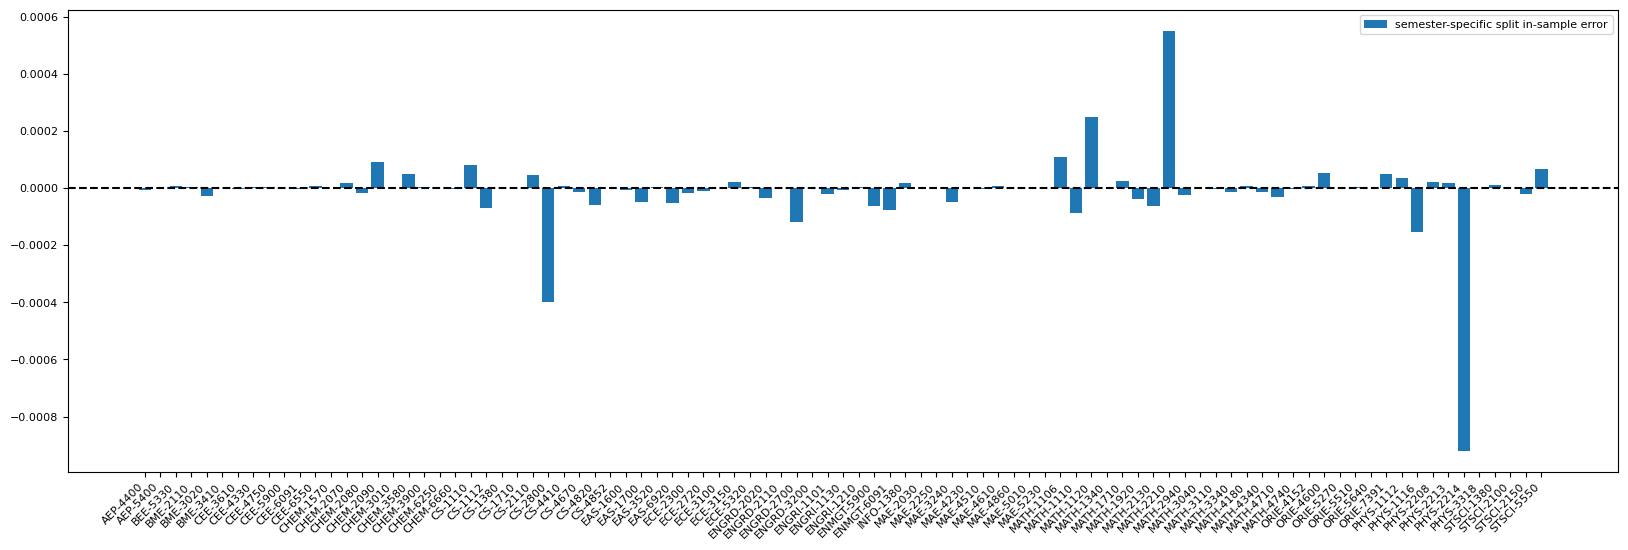

In [230]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))


plt.axhline(y=0, color='black', linestyle='--')

plt.bar(eng_filtered_exams, np.array(in_sample_diff),
        align = 'center', label = 'semester-specific split in-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();

In [8]:
out_sample_diff = np.array(out_sample_diff)
print(f'{sum(out_sample_diff > 0)} courses predict more drops')
print(f'On average, the model predicts {out_sample_diff[out_sample_diff >0].mean()} more drops')
print(f'{sum(out_sample_diff < 0)} courses predict fewer drops')
print(f'On average, the model predicts {-1 * out_sample_diff[out_sample_diff <0].mean()} fewer drops')
print(f'In median, the model predicts {-1 * np.median(out_sample_diff[out_sample_diff <0])} fewer drops')
print(f'Semester-specific Prediction Mean Squared Error (MSE) is {np.mean(out_sample_diff**2)}')

4 courses predict more drops
On average, the model predicts 1.3871510609980426 more drops
87 courses predict fewer drops
On average, the model predicts 16.31214162086242 fewer drops
In median, the model predicts 8.218706966120681 fewer drops
Semester-specific Prediction Mean Squared Error (MSE) is 547.2521664380707


In [243]:
# # create figure and axes objects

# fig, ax1 = plt.subplots(figsize=(20,6))

# # plot first bar plot on the first y-axis
# ax1.bar(np.arange(len(eng_filtered_exams))-0.2, -1 * np.array(out_sample_diff),
#         align='center', label='semester-specific split out-of-sample error', width=0.4, color='C0')
# ax1.set_xticks(range(len(eng_filtered_exams)))
# ax1.set_xticklabels(eng_filtered_exams, rotation=45, ha='right')
# ax1.legend(loc='best')
# ax1.set_ylim(bottom=-10)


# # create second y-axis on the right side of the plot
# ax2 = ax1.twinx()
# # plot second bar plot on the second y-axis
# ax2.bar(np.arange(len(eng_filtered_exams))+0.2, -1* np.array(relative_out_sample_diff)*100,
#         align='center', label='semester-specific split relative out-of-sample error', width=0.4, color='C1')
# ax2.set_ylabel('Relative Error (%)')
# ax2.legend(loc='best', bbox_to_anchor=(0.7, 1))

# # set plot title and axis labels
# ax1.set_title('Comparison of Out-of-Sample Error')
# ax1.set_ylabel('Error')

# # add horizontal line at y=0
# # ax1.axhline(y=0, color='black', linestyle='--')

# plt.show()

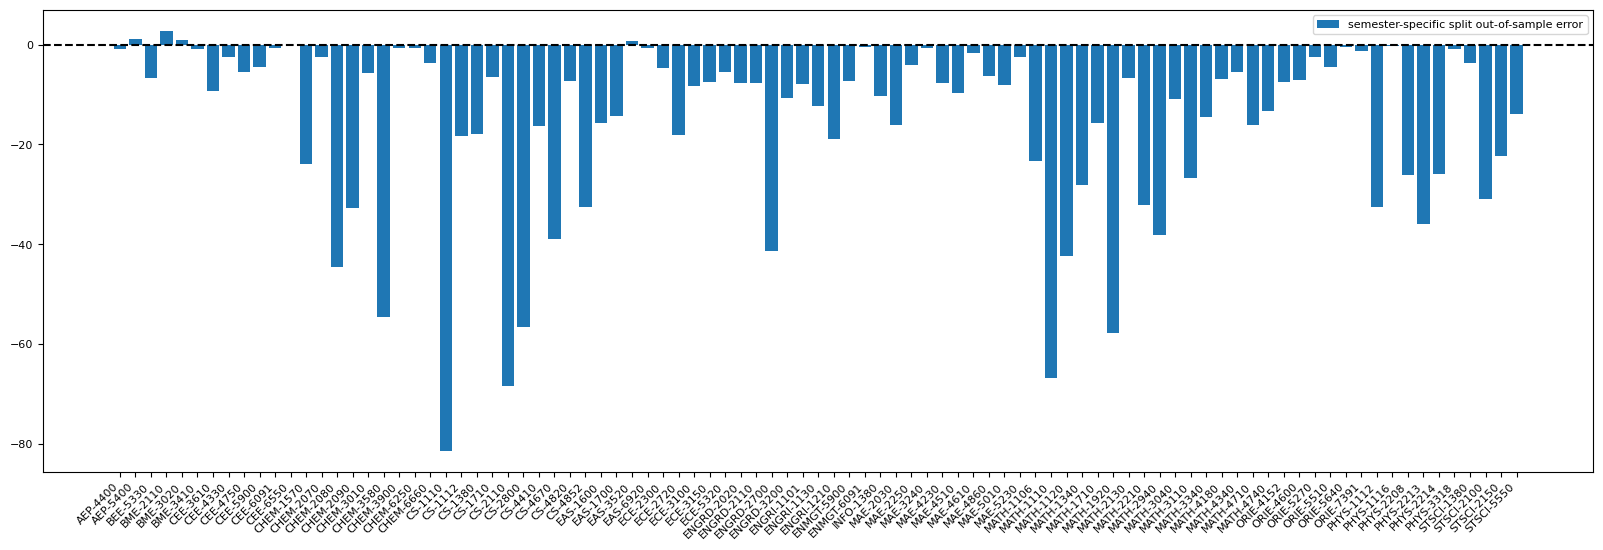

In [238]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))


plt.axhline(y=0, color='black', linestyle='--')

plt.bar(eng_filtered_exams, np.array(out_sample_diff),
        align = 'center', label = 'semester-specific split out-of-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();

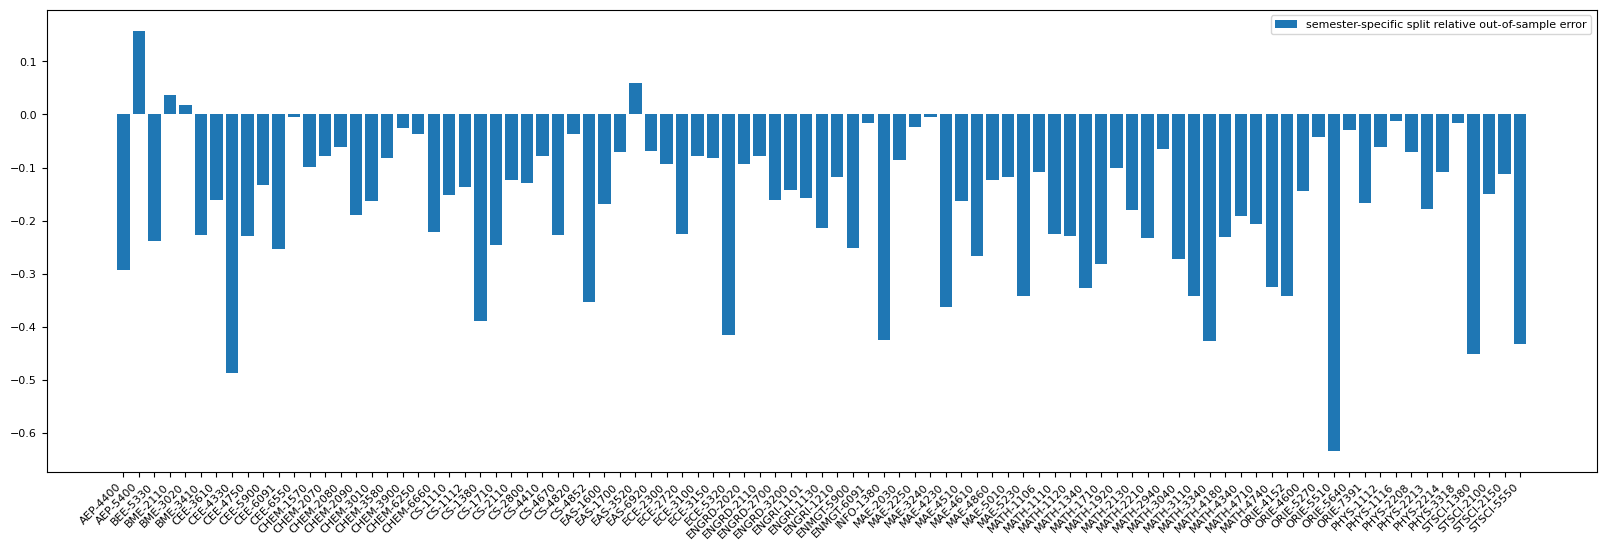

In [239]:
# plt.axhline(y=0, color='black', linestyle='--')
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))
plt.bar(eng_filtered_exams, np.array(relative_out_sample_diff),
        align = 'center', label = 'semester-specific split relative out-of-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();

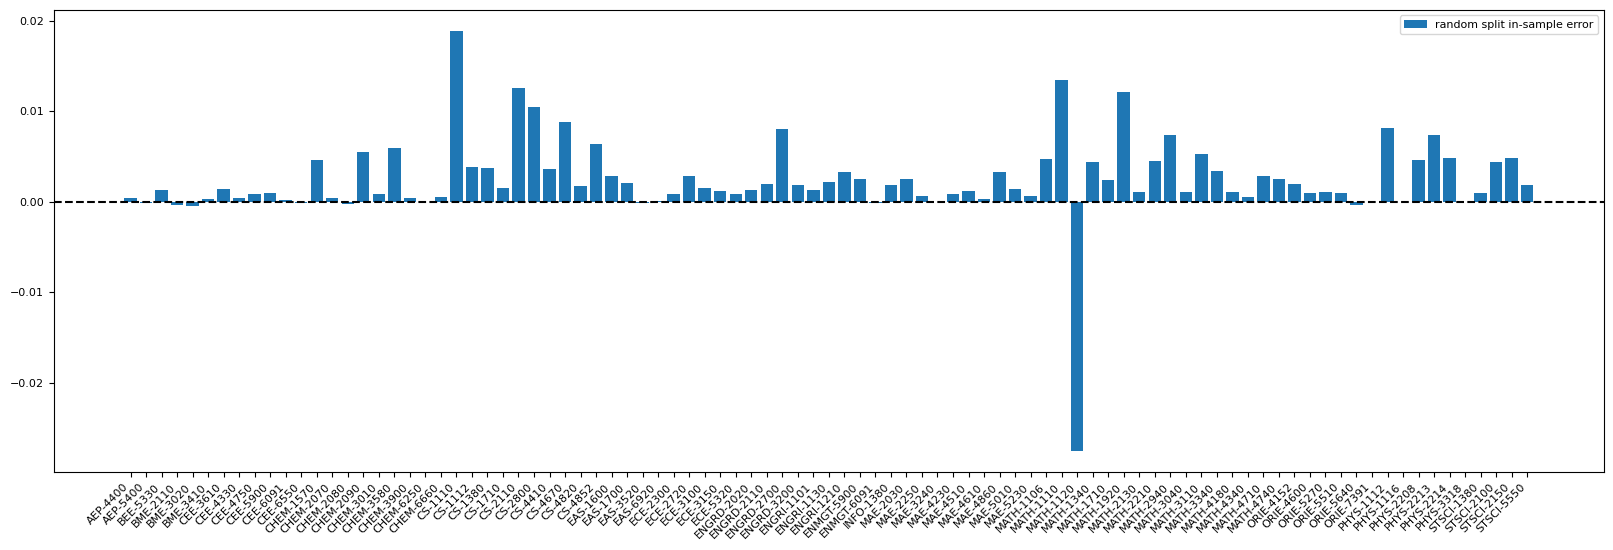

In [240]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))


plt.axhline(y=0, color='black', linestyle='--')

plt.bar(eng_filtered_exams, np.array(rnd_in_sample_diff),
        align = 'center', label = 'random split in-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();

In [11]:
rnd_out_sample_diff = np.array(rnd_out_sample_diff)
print(f'Random Split Prediction Mean Squared Error (MSE) is {np.mean(rnd_out_sample_diff**2)}')

Random Split Prediction Mean Squared Error (MSE) is 0.34953519762450225


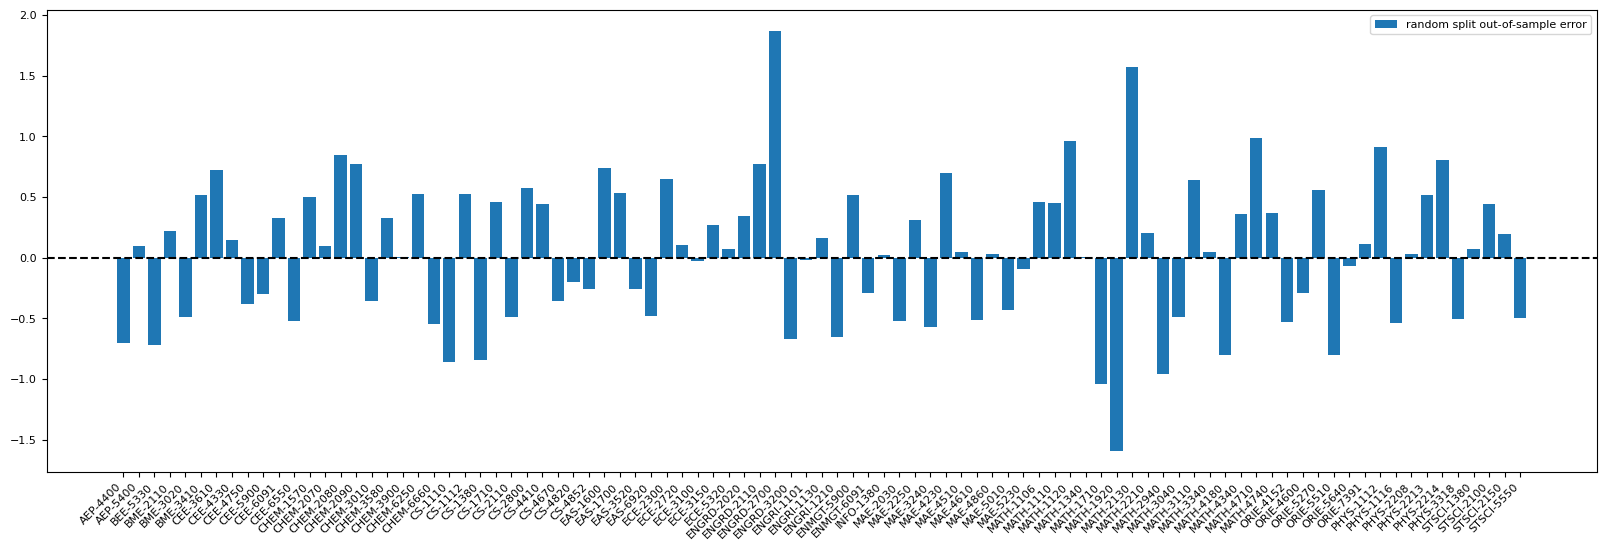

In [241]:
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 6))


plt.axhline(y=0, color='black', linestyle='--')

plt.bar(eng_filtered_exams, np.array(rnd_out_sample_diff),
        align = 'center', label = 'random split out-of-sample error')

plt.xticks(range(len(eng_filtered_exams)), eng_filtered_exams, rotation=45, ha='right');
plt.legend();